<a href="https://colab.research.google.com/github/kolayn808/OpenAttack/blob/main/XAI_Train_RoBERTa_graph.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/

Mounted at /content/drive
/content/drive/MyDrive


Подключение необходимых библиотек

In [2]:
!git clone https://github.com/epfml/interpret-lm-knowledge.git
!pip install git+https://github.com/huggingface/transformers
!pip list | grep -E 'transformers|tokenizers'
!pip install textacy
!pip install transformers[torch]
!pip install accelerate -U

fatal: destination path 'interpret-lm-knowledge' already exists and is not an empty directory.
  Cloning https://github.com/huggingface/transformers to /tmp/pip-req-build-635_cywz
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/transformers /tmp/pip-req-build-635_cywz
  Resolved https://github.com/huggingface/transformers to commit 3b7675b2b844b02d4821b827871a21ad16dd446c
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for transformers: filename=transformers-4.37.0.dev0-py3-none-any.whl size=8281626 sha256=f4affe72f5a88d2ead9d8e4e17fd72df18012f525f85df65eebf744e134ff7ce
  Stored in directory: /tmp/pip-ephem-wheel-cache-xg7y1elc/wheels/c0/14/d6/6c9a5582d2ac191ec0a483be151a4495fe1eb2a6706ca49f1b
Successfully built transformers
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.2
    Uninstalling transformers-4.35

In [3]:
import sys
from gensim.corpora import WikiCorpus

def make_corpus(in_f, out_f):

    """Конвертирование wikipedia xml файла в текстовый корпус"""

    output = open(out_f, 'w')
    print('starting corpus')
    wiki = WikiCorpus(in_f)
    print('loaded corpus')

    i = 0
    for text in wiki.get_texts():
        output.write(bytes(' '.join(text), 'utf-8').decode('utf-8') + '\n')
        i = i + 1
    if (i % 100 == 0):
        print('Processed ' + str(i) + ' articles')
    output.close()
    print('Процесс завершен!')

In [4]:
%%time
from pathlib import Path

from tokenizers import ByteLevelBPETokenizer

paths = ['wiki_en_10.txt']

# Выбор токенайзера
tokenizer = ByteLevelBPETokenizer()

# индивидуальное обучение
# размер словаря: vocab_size=52_000
tokenizer.train(files=paths, vocab_size=52_000, min_frequency=2, special_tokens=[
    "<s>",
    "<pad>",
    "</s>",
    "<unk>",
    "<mask>",
])

CPU times: user 1.34 s, sys: 201 ms, total: 1.55 s
Wall time: 1.27 s


In [6]:
!mkdir wikipedia_model_3e
tokenizer.save_model("wikipedia_model_3e")

['wikipedia_model_3e/vocab.json', 'wikipedia_model_3e/merges.txt']

In [7]:
from tokenizers.implementations import ByteLevelBPETokenizer
from tokenizers.processors import BertProcessing


tokenizer = ByteLevelBPETokenizer(
    "./wikipedia_model_3e/vocab.json",
    "./wikipedia_model_3e/merges.txt",
)

tokenizer._tokenizer.post_processor = BertProcessing(
    ("</s>", tokenizer.token_to_id("</s>")),
    ("<s>", tokenizer.token_to_id("<s>")),
)
tokenizer.enable_truncation(max_length=512)


tokenizer.encode("I am a fireman.").tokens

['<s>', 'I', 'Ġam', 'Ġa', 'Ġfire', 'man', '.', '</s>']

Проверка GPU

In [8]:
!nvidia-smi

Tue Dec 26 18:32:07 2023       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8               9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

Проверка что PyTorch видит GPU

In [9]:
import torch
torch.cuda.is_available()

True

Установка конфигурации модели

In [10]:
from transformers import RobertaConfig

config = RobertaConfig(
    vocab_size=52_000,
    max_position_embeddings=514,
    num_attention_heads=12,
    num_hidden_layers=6,
    type_vocab_size=1,
)

In [11]:
from transformers import RobertaTokenizerFast

tokenizer = RobertaTokenizerFast.from_pretrained("./wikipedia_model_3e", max_len=512)

In [12]:
from transformers import RobertaForMaskedLM

model = RobertaForMaskedLM(config=config)

In [13]:
model.num_parameters()

83504416

In [14]:
%%time
from transformers import LineByLineTextDataset

dataset = LineByLineTextDataset(
    tokenizer=tokenizer,
    file_path="/content/drive/MyDrive/wiki_en_10.txt",
    block_size=128,
)

/usr/local/lib/python3.10/dist-packages/transformers/data/datasets/language_modeling.py:119: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


CPU times: user 4.23 s, sys: 308 ms, total: 4.54 s
Wall time: 4.88 s


In [15]:
from transformers import DataCollatorForLanguageModeling

data_collator = DataCollatorForLanguageModeling(
    tokenizer=tokenizer, mlm=True, mlm_probability=0.15
)

In [16]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir="./wikipedia_model_3e",
    overwrite_output_dir=True,
    num_train_epochs=3,
    per_device_train_batch_size=64,
    save_steps=10_000
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=dataset
)

In [17]:
%%time
trainer.train()

You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss


CPU times: user 3min 29s, sys: 552 ms, total: 3min 30s
Wall time: 3min 39s


TrainOutput(global_step=183, training_loss=8.337996686091188, metrics={'train_runtime': 219.7229, 'train_samples_per_second': 52.675, 'train_steps_per_second': 0.833, 'total_flos': 383756619497472.0, 'train_loss': 8.337996686091188, 'epoch': 3.0})

In [18]:
trainer.save_model("./wikipedia_model_3e")

In [19]:
from transformers import pipeline

unmasker = pipeline(
    "fill-mask",
    model="./wikipedia_model_3e",
    tokenizer="./wikipedia_model_3e"
)

In [20]:
%cd /content/drive/MyDrive/interpret-lm-knowledge/scripts/
from run_training_kg_experiments import *

run_experiments(tokenizer, model, unmasker, experiment_model, extractor, "Roberta3e")

/content/drive/MyDrive/interpret-lm-knowledge/scripts


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.weight', 'bert.pooler.dense.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
<ipython-input-33-79478ef34385>:71: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dfItem, ignore_index=True)
<ipython-input-33-79478ef34385>:71: FutureWarning: The frame.append method is deprecated and will be

Выполнено!


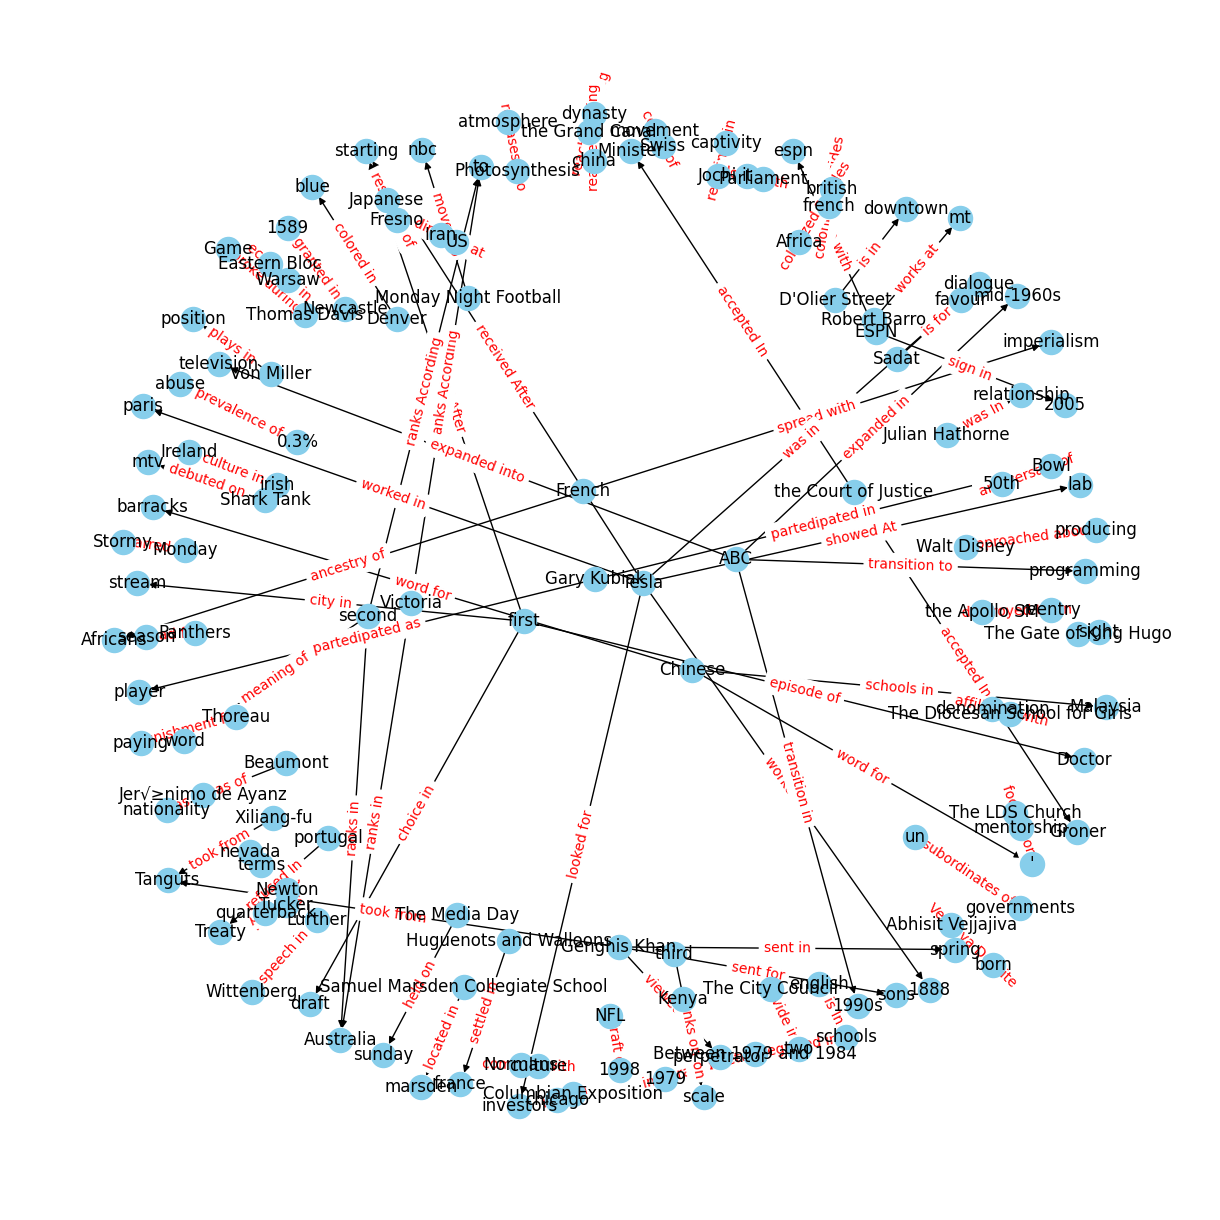

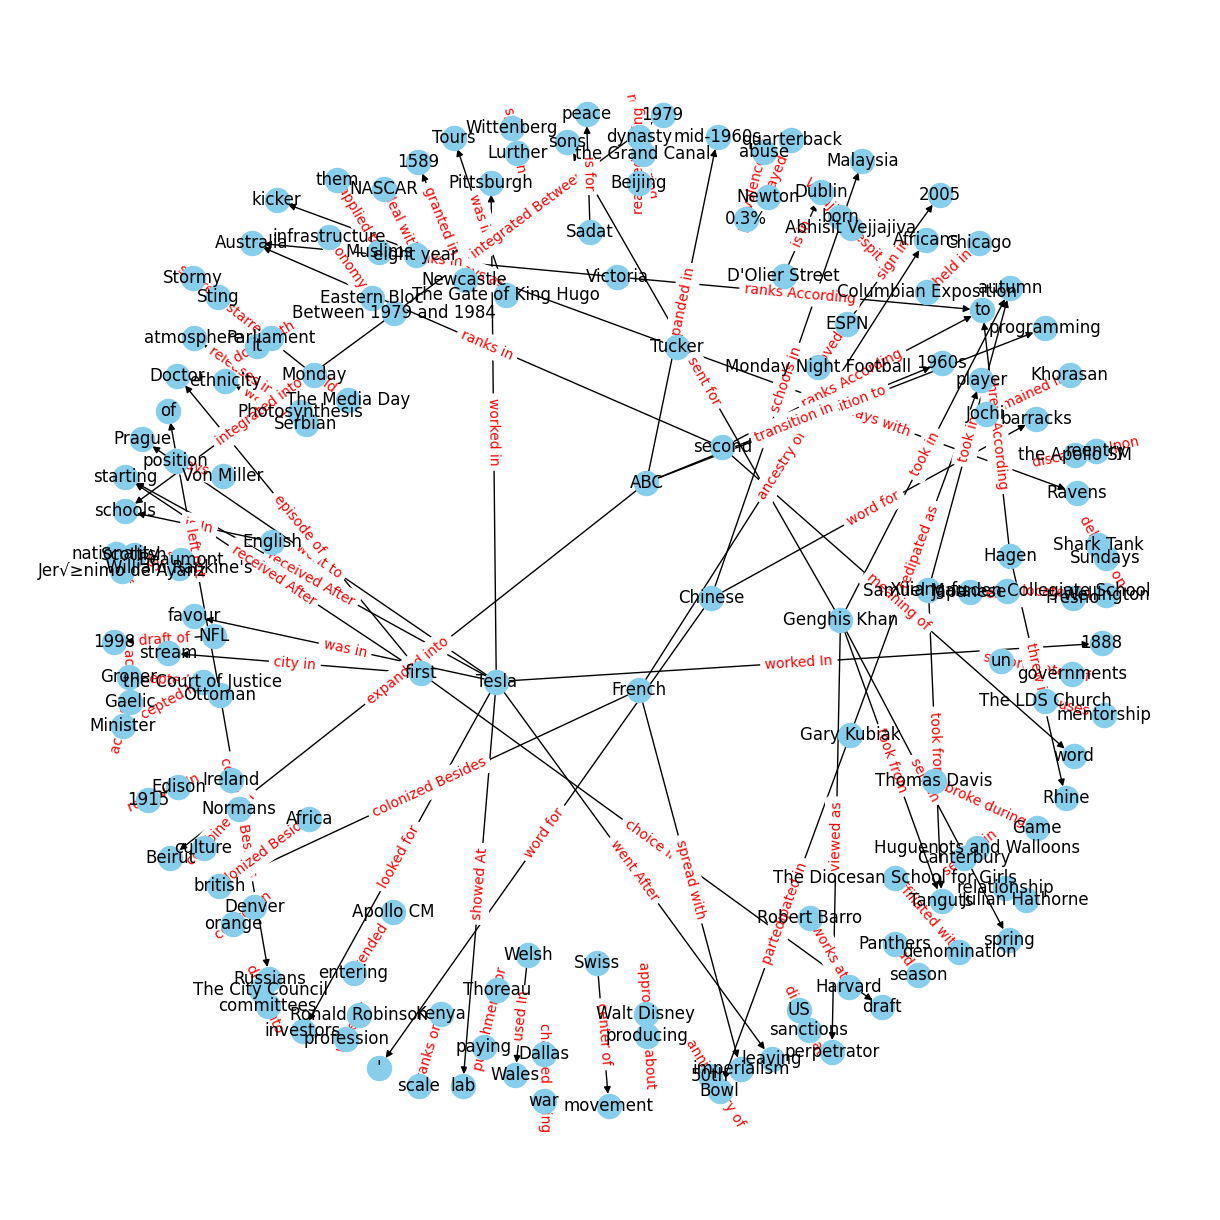

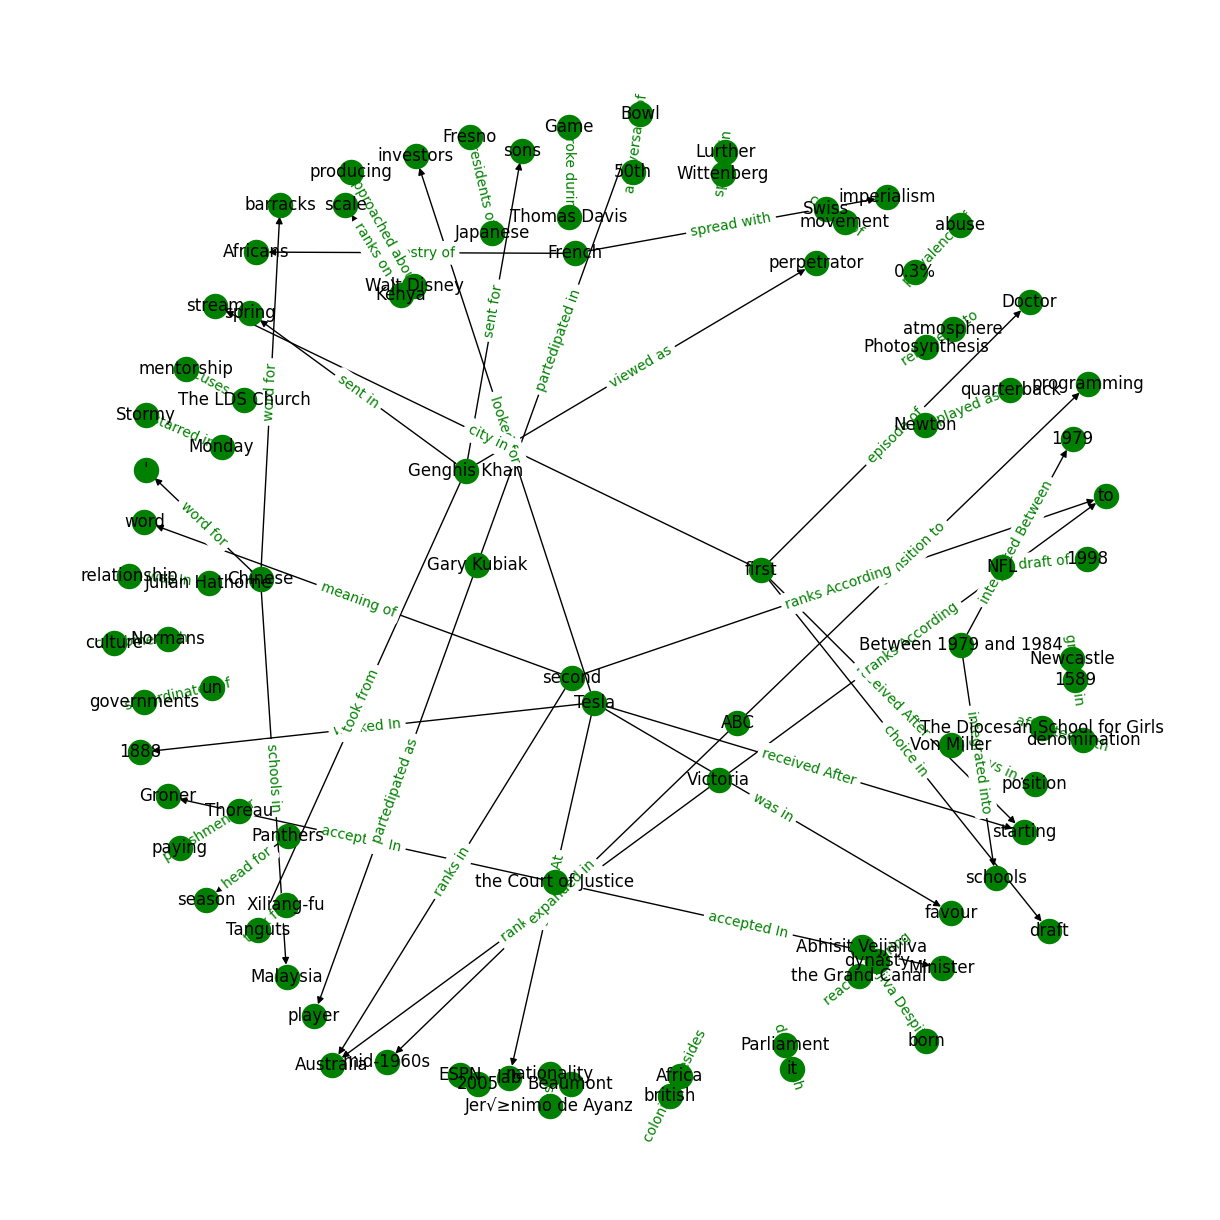

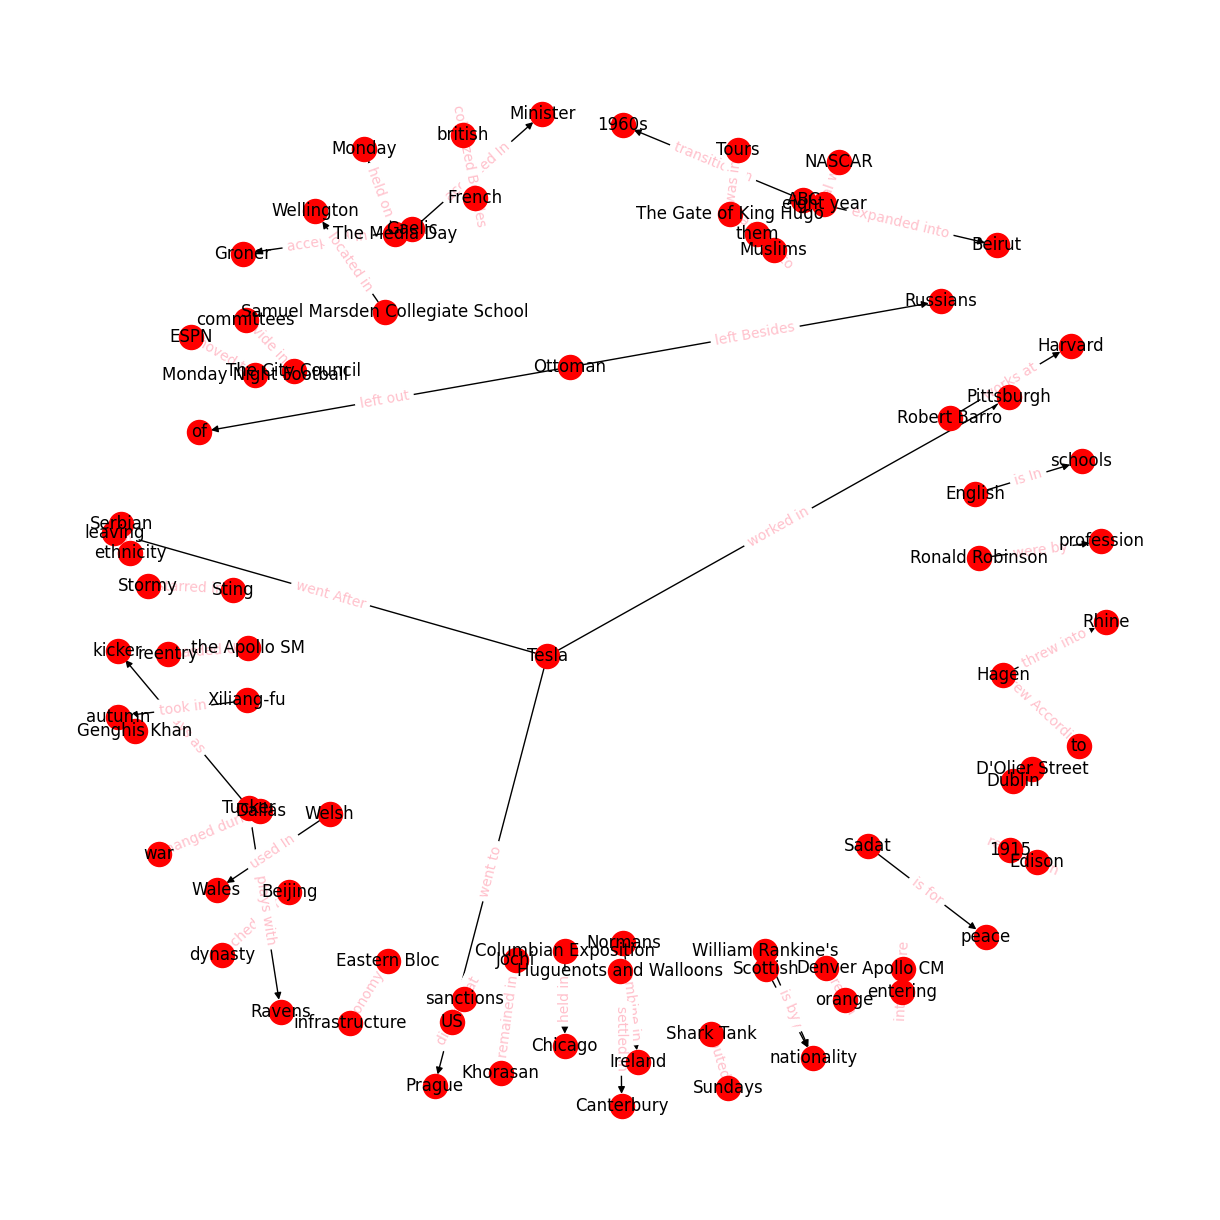

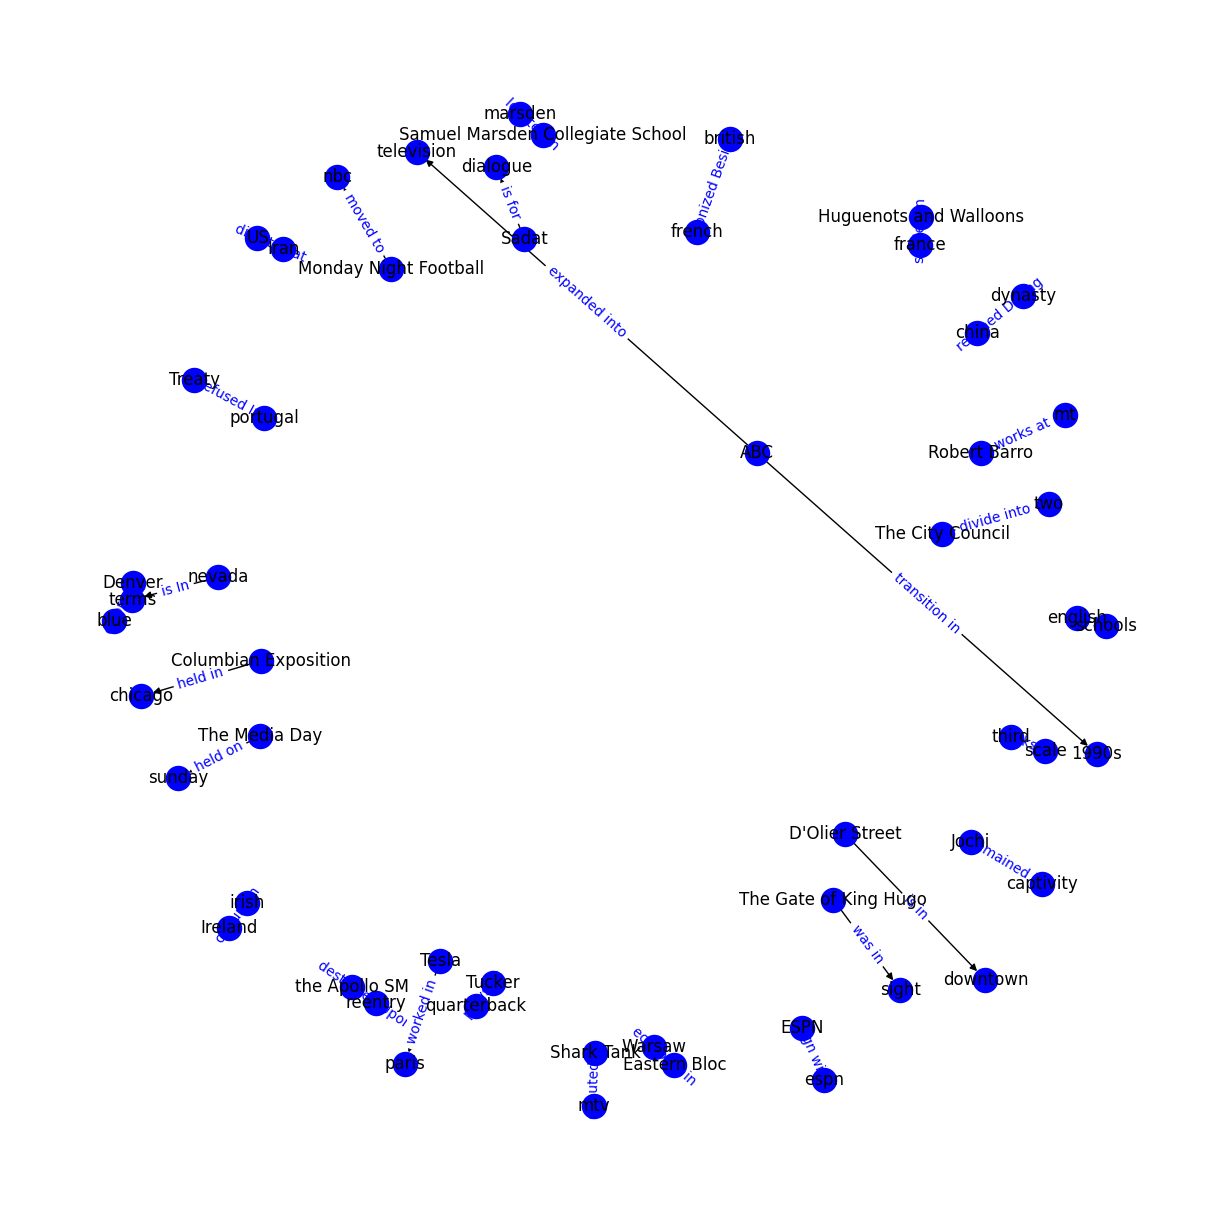

In [33]:
import urllib.request
import zipfile
from transformers import pipeline
import json
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import spacy
import textacy


# базы данных для эксперимента. Может принимать значения: squad, re-date-birth, re-place-birth, re-place-death
experiment_data = 'squad'
# используемая модель. Может принимать значения: Bert, DistilBert, Roberta
experiment_model = 'Bert'
use_spacy = True


def preprocess_masks(df, experiment_data, experiment_model):
    good_preds_ids = []
    predicted_sentences = []
    ground_truth_sentences = []
    valid_examples = len(df)
    for i in range(len(df)):
      mask = df['masked_sentences'][i]
      if mask.count('[MASK]') > 1 or mask.count('[MASK]') == 0:
        valid_examples -= 1
        continue
      if 're' in experiment_data:
        gold_label = df['obj'][i]
      else:
        gold_label = df['obj_label'][i]
      if 'Roberta' in experiment_model:
        mask = mask.replace('[MASK]', '<mask>')
      preds = pd.DataFrame(unmasker(mask))['token_str']
      if any(preds.str.contains(gold_label)):
        good_preds_ids.append(i)
      top_pred = preds[0]
      if 'Roberta' in experiment_model:
        full_sentence = mask.replace('<mask>', top_pred)
        ground_truth_sentence = mask.replace('<mask>', gold_label)
      else:
        full_sentence = mask.replace('[MASK]', top_pred)
        ground_truth_sentence = mask.replace('[MASK]', gold_label)
      predicted_sentences.append(full_sentence)
      ground_truth_sentences.append(ground_truth_sentence)
    return good_preds_ids, predicted_sentences, ground_truth_sentences, valid_examples

def generate_df(data_type='squad'):
    if data_type == 'squad':
        file = 'data/data/Squad/test.jsonl'
    elif data_type == 're-date-birth':
        file = 'data/data/Google_RE/date_of_birth_test.jsonl'
    elif data_type == 're-place-birth':
        file = 'data/data/Google_RE/place_of_birth_test.jsonl'
    elif data_type == 're-place-death':
        file = 'data/data/Google_RE/place_of_death_test.jsonl'
    else:
        raise NameError("Data file ", data_type, "not available.")

    with open(file, 'r') as json_file:
        json_list = list(json_file)

    df = pd.DataFrame()
    for json_str in json_list:
        result = json.loads(json_str)
        if 're' in data_type:
            dfItem = pd.DataFrame.from_dict({'masked_sentences': result['masked_sentences'], 'obj': str(result['obj'][:4])})
        else:
            dfItem = pd.DataFrame.from_records(result)
        df = df.append(dfItem, ignore_index=True)
    return df

def textacy_extract_relations(text):
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(text)
    return textacy.extract.subject_verb_object_triples(doc)

def spacy_extract_relations(text):
    nlp = spacy.load("en_core_web_sm")
    doc = nlp(text)
    triples = []

    for ent in doc.ents:
        preps = [prep for prep in ent.root.head.children if prep.dep_ == "prep"]
        for prep in preps:
            for child in prep.children:
                triples.append((ent.text, "{} {}".format(ent.root.head, prep), child.text))

    return triples

def retrieve_data():
    url = "https://dl.fbaipublicfiles.com/LAMA/data.zip"
    extract_dir = "data"

    zip_path, _ = urllib.request.urlretrieve(url)
    with zipfile.ZipFile(zip_path, "r") as f:
        f.extractall(extract_dir)

def retrive_models(experiment_model):
    if experiment_model == 'DistilBert':
        from transformers import DistilBertTokenizer, DistilBertModel
        tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
        model = DistilBertModel.from_pretrained("distilbert-base-uncased")
        unmasker = pipeline('fill-mask', model='distilbert-base-uncased')
    elif experiment_model == 'Bert':
        from transformers import BertTokenizer, BertModel
        tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
        model = BertModel.from_pretrained("bert-base-uncased")
        unmasker = pipeline('fill-mask', model='bert-base-uncased')
    elif experiment_model == 'Roberta':
        from transformers import RobertaTokenizer, RobertaModel
        tokenizer = RobertaTokenizer.from_pretrained('roberta-base')
        model = RobertaModel.from_pretrained("roberta-base")
        unmasker = pipeline('fill-mask', model='roberta-base')
    else:
        raise NameError("Model has not been implemented yet.")
    return tokenizer, model, unmasker

def generate_kg(predicted_sentences, use_spacy=False):
    nlp = spacy.load("en_core_web_sm")
    label_dict = {}
    row_list = []
    if use_spacy:
        extract_relations = spacy_extract_relations
    else:
        extract_relations = textacy_extract_relations

    for text in predicted_sentences:
        relations = extract_relations(text)
        for _source, _relation, _target in relations:
          row_list.append({'source': str(_source), 'target':str(_target), 'edge': str(_relation)})
          label_dict[(str(_source), str(_target))] = str(_relation)

    return pd.DataFrame(row_list), label_dict

def plot_kg(df, label_dict, node_color='skyblue', font_color='red', save_name='img.jpg'):
    G=nx.from_pandas_edgelist(df, "source", "target",
                              edge_attr=True, create_using=nx.MultiDiGraph())

    plt.figure(figsize=(12,12))

    pos = nx.spring_layout(G)
    nx.draw(G, with_labels=True, node_color=node_color, edge_cmap=plt.cm.Blues, pos = pos)
    nx.draw_networkx_edge_labels(G,pos,edge_labels=label_dict,font_color=font_color)
    plt.savefig(save_name)

def generate_merge_df(labels):
    n_df = pd.DataFrame(labels, columns=['source', 'edge'])
    merge_df = pd.DataFrame(n_df['source'].values.tolist(), index=n_df.index, columns=['source', 'target'])
    merge_df['edge'] = n_df['edge']
    return merge_df

retrieve_data()
tokenizer, model, unmasker = retrive_models(experiment_model)

df = generate_df(experiment_data)
good_preds_ids, predicted_sentences, ground_truth_sentences, \
                valid_examples = preprocess_masks(df, experiment_data, experiment_model)

# предсказания языковой модели
kg_df, label_dict = generate_kg(predicted_sentences, use_spacy)
kg_df.to_csv(experiment_data + '_' + experiment_model + '_kg_df.csv')

plot_kg(kg_df, label_dict, 'skyblue', 'red', \
        experiment_data + '_' + experiment_model + '_kg.jpg')

# достоверные предсказания
g_kg_df, g_label_dict = generate_kg(ground_truth_sentences, use_spacy)
g_kg_df.to_csv(experiment_data + '_' + experiment_model + '_g_kg_df.csv')

plot_kg(g_kg_df, g_label_dict, 'skyblue', 'red', \
        experiment_data + '_' + experiment_model + '_g_kg.jpg')

# сравнение достоверных предсказаний и предсказаний языковой модели
ground_truth_set = set(g_label_dict.items())
relations_set = set(label_dict.items())
intersection_labels = ground_truth_set.intersection(relations_set)
new_relations = relations_set.difference(ground_truth_set)
missed_ground_truth = ground_truth_set.difference(relations_set)

#  отношения, зафиксированные обеими моделями
intersection_df = generate_merge_df(intersection_labels)
intersection_df.to_csv(experiment_data + '_' + experiment_model + '_intersection.csv')
plot_kg(intersection_df, dict(intersection_labels), 'green', 'green', \
        experiment_data + '_' + experiment_model + '_intersection.jpg')

# отношения, имеющиеся в достоверных предсказаниях и пропущенные языковой моделью
missed_ground_truth_df = generate_merge_df(missed_ground_truth)
missed_ground_truth_df.to_csv(experiment_data + '_' + experiment_model + '_missed_ground_truth.csv')
plot_kg(missed_ground_truth_df, dict(missed_ground_truth), 'red', 'pink', \
        experiment_data + '_' + experiment_model + '_missed_ground_truth.jpg')

# новые отношения, зафиксированные языковой моделью и отсутствующие в достоверных предсказаниях
new_lm_relations_df = generate_merge_df(new_relations)
new_lm_relations_df.to_csv(experiment_data + '_' + experiment_model + '_new_lm_relations.csv')
plot_kg(new_lm_relations_df, dict(new_relations), 'blue', 'blue', \
        experiment_data + '_' + experiment_model + '_new_lm_relations.jpg')

print('Выполнено!')




